In [1]:
%matplotlib inline 
%matplotlib inline

import numpy as np # linear algebra
import scipy.ndimage
import matplotlib.pyplot as plt
import dicom as dicom # for reading dicom files
import os # for doing directory operations 
import pandas as pd # for some simple data analysis (right now, just to load in the labels data and quickly reference it)
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection



# Change this to wherever you are storing your data:
# IF YOU ARE FOLLOWING ON KAGGLE, YOU CAN ONLY PLAY WITH THE SAMPLE DATA, WHICH IS MUCH SMALLER

data_dir = 'Lung/NSCLC-Radiomics/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('lung1.clinical.csv', index_col=0)
labels_df=labels_df.drop(['age','Clinical.N.Stage','Clinical.M.Stage','Overall.Stage','Histology','gender','Survival.time', 'deadstatus.event'],axis=1)

labels_df.head()


,clinical.T.Stage
PatientID,
LUNG1-001,2.0
LUNG1-002,2.0
LUNG1-003,2.0
LUNG1-004,2.0
LUNG1-005,4.0


In [2]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'clinical.T.Stage')
    path = data_dir + patient
    
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
    print(len(slices),label)
    print(slices[0])

C:\Users\Abigail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


134 2.0
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.32722.99.99.41277525157876544037153507755141737313
(0008, 0020) Study Date                          DA: '20080918'
(0008, 0021) Series Date                         DA: '20080918'
(0008, 0022) Acquisition Date                    DA: '20080918'
(0008, 0023) Content Date                        DA: '20080918'
(0008, 0030) Study Time                          TM: '110915.625000'
(0008, 0031) Series Time                         TM: '121748.328000'
(0008, 0032) Acquisition Time                    TM: '113944.541817'
(0008, 0033) Content Time                        TM: '113944.541817'
(0008, 0050) Accession Number                    SH: '2819497684894126'
(0008, 0060) Modality              

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

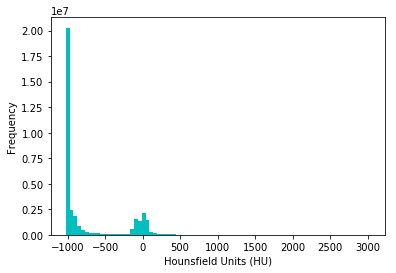

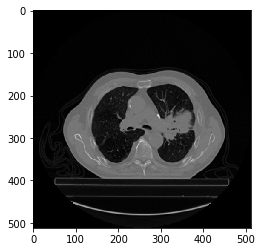

In [4]:
first_patient = slices
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [5]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [6]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (402, 500, 500)


In [20]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

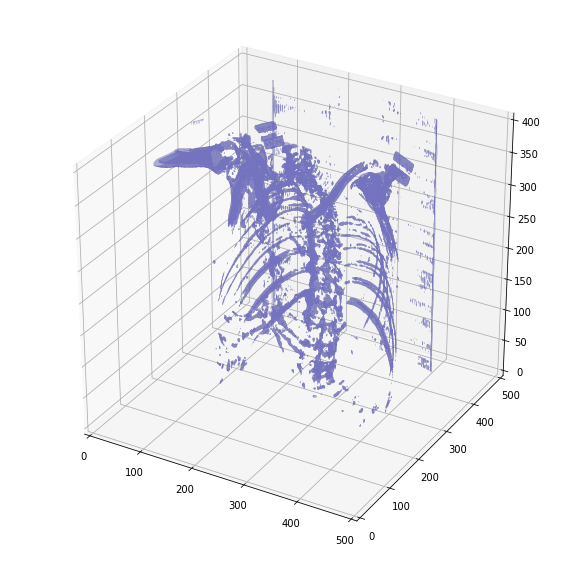

In [23]:
plot_3d(pix_resampled, 450)

In [24]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [26]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (134, 512, 512)
Shape after resampling	 (402, 500, 500)


In [27]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

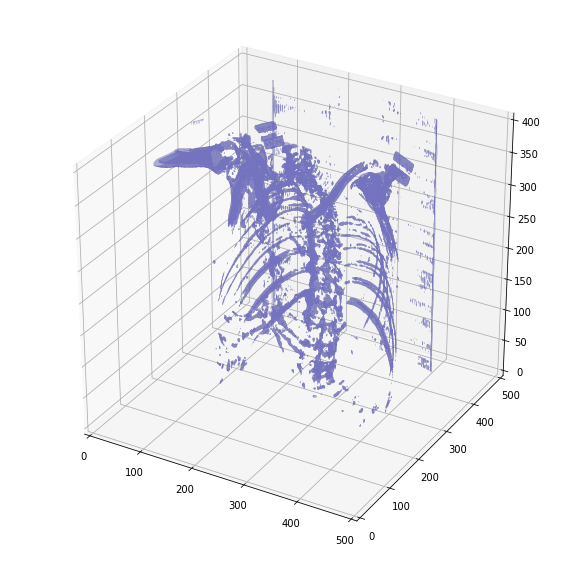

In [28]:
plot_3d(pix_resampled, 450)

In [29]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image


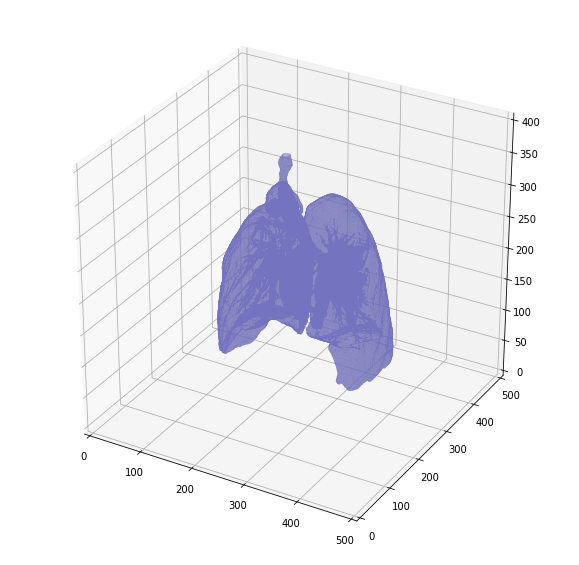

In [32]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
plot_3d(segmented_lungs, 0)

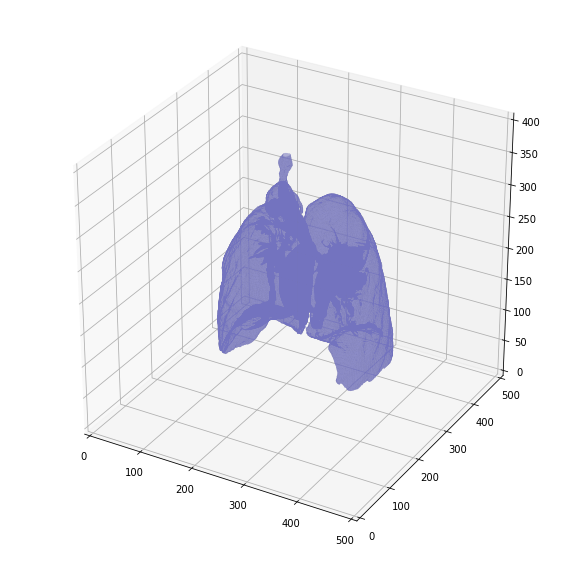

In [33]:
plot_3d(segmented_lungs_fill, 0)

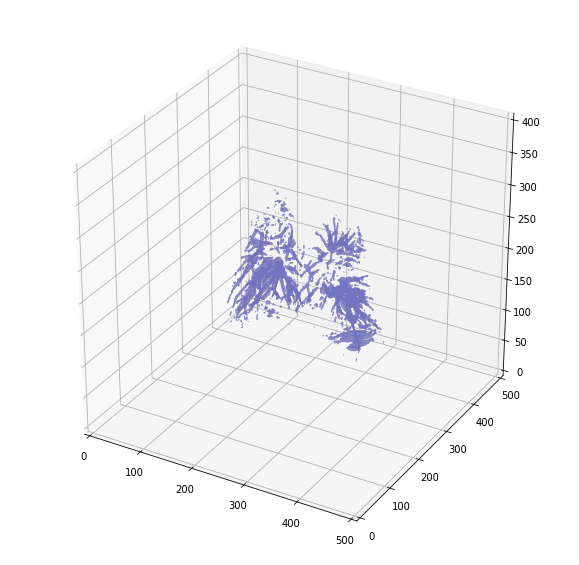

In [34]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)

In [37]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'clinical.T.Stage')
    path = data_dir + patient
    
    # a couple great 1-liners from: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    print(slices[0].pixel_array.shape, len(slices))

C:\Users\Abigail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


(512, 512) 134


C:\Users\Abigail\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.


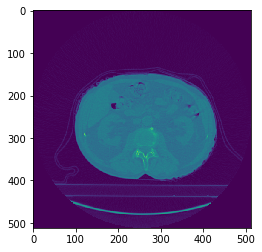

In [38]:
import matplotlib.pyplot as plt

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'clinical.T.Stage')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    #          the first slice
    plt.imshow(slices[0].pixel_array)
    plt.show()

C:\Users\Abigail\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


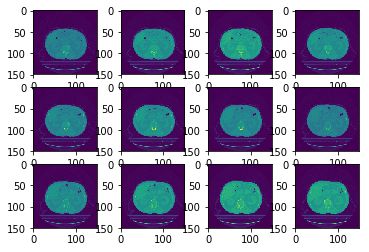

In [42]:
os.sys.path
import cv2
import numpy as np

IMG_PX_SIZE = 150

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'clinical.T.Stage')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    fig = plt.figure()
    for num,each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4,num+1)
        new_img = cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE))
        y.imshow(new_img)
    plt.show()

In [46]:
import math

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def mean(l):
    return sum(l) / len(l)

IMG_PX_SIZE = 150
HM_SLICES = 20

data_dir = 'Lung/NSCLC-Radiomics/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('lung1.clinical.csv', index_col=0)

for patient in patients[:1]:
    try:
        label = labels_df.get_value(patient, 'clinical.T.Stage')
        path = data_dir + patient
        slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
        slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
        new_slices = []
        slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
        chunk_sizes = math.ceil(len(slices) / HM_SLICES)
        for slice_chunk in chunks(slices, chunk_sizes):
            slice_chunk = list(map(mean, zip(*slice_chunk)))
            new_slices.append(slice_chunk)

        print(len(slices), len(new_slices))
    except:
        # some patients don't have labels, so we'll just pass on this for now
        pass

C:\Users\Abigail\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


134 20


C:\Users\Abigail\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


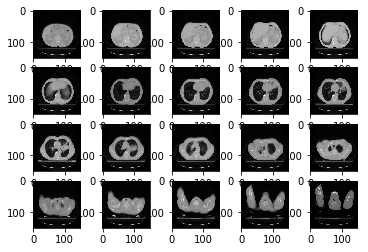

In [47]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'clinical.T.Stage')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    new_slices = []

    slices = [cv2.resize(np.array(each_slice.pixel_array),(IMG_PX_SIZE,IMG_PX_SIZE)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / HM_SLICES)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    if len(new_slices) == HM_SLICES-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == HM_SLICES+2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
        
    if len(new_slices) == HM_SLICES+1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1],new_slices[HM_SLICES],])))
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
    
    fig = plt.figure()
    for num,each_slice in enumerate(new_slices):
        y = fig.add_subplot(4,5,num+1)
        y.imshow(each_slice, cmap='gray')
    plt.show()

In [68]:
import numpy as np
import pandas as pd
import dicom
import os
import matplotlib.pyplot as plt
import cv2
import math

IMG_SIZE_PX = 50
SLICE_COUNT = 5

def chunks(l, n):
    # Credit: Ned Batchelder
    # Link: http://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def mean(a):
    return sum(a) / len(a)


def process_data(patient,labels_df,img_px_size=50, hm_slices=20, visualize=False):
    
    label = labels_df.get_value(patient, 'clinical.T.Stage')
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))

    new_slices = []
    slices = [cv2.resize(np.array(each_slice.pixel_array),(img_px_size,img_px_size)) for each_slice in slices]
    
    chunk_sizes = math.ceil(len(slices) / hm_slices)
    for slice_chunk in chunks(slices, chunk_sizes):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)
    
    if len(new_slices) == hm_slices-1:
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices-2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])

    if len(new_slices) == hm_slices+2:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val
        
    if len(new_slices) == hm_slices+1:
        new_val = list(map(mean, zip(*[new_slices[hm_slices-1],new_slices[hm_slices],])))
        del new_slices[hm_slices]
        new_slices[hm_slices-1] = new_val

    if visualize:
        fig = plt.figure()
        for num,each_slice in enumerate(new_slices):
            y = fig.add_subplot(4,5,num+1)
            y.imshow(each_slice, cmap='gray')
        plt.show()

    if label == 1: label=np.array([0,1])
    elif label == 0: label=np.array([1,0])
        
    return np.array(new_slices),label

#                                               stage 1 for real.
data_dir = 'Lung/NSCLC-Radiomics/'
patients = os.listdir(data_dir)
labels = pd.read_csv('lung1.clinical.csv', index_col=0)

much_data = []
for num,patient in enumerate(patients[:5]):
    if num % 100 == 0:
        print(num)
    try:
        img_data,label = process_data(patient,labels,img_px_size=IMG_SIZE_PX, hm_slices=SLICE_COUNT)
        #print(img_data.shape,label)
        much_data.append([img_data,label])
    except KeyError as e:
        print('This is unlabeled data!')

np.save('muchdata-{}-{}-{}.npy'.format(IMG_SIZE_PX,IMG_SIZE_PX,SLICE_COUNT), much_data)


0


C:\Users\Abigail\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [74]:
import tensorflow as tf
import numpy as np

IMG_SIZE_PX = 50
SLICE_COUNT = 5

n_classes = 2

batch_size = 10

x = tf.placeholder('float')
y = tf.placeholder('float')

keep_rate=0.8
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1,1,1,1,1], padding='SAME')

def maxpool3d(x):
    #                        size of window         movement of window as you slide about
    return tf.nn.max_pool3d(x, ksize=[1,2,2,2,1], strides=[1,2,2,2,1], padding='SAME')


In [75]:
def convolutional_neural_network(x):
    #                # 5 x 5 x 5 patches, 1 channel, 32 features to compute.
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [81]:
much_data = np.load('muchdata-50-50-5.npy')
# If you are working with the basic sample data, use maybe 2 instead of 100 here... you don't have enough data to really do this
train_data = much_data[:-2]
validation_data = much_data[-2:]

def train_neural_network(x):
    prediction = convolutional_neural_network(x)
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
    
    hm_epochs = 2
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        
        successful_runs = 0
        total_runs = 0
        
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for data in train_data:
                total_runs += 1
                try:
                    X = data[0]
                    Y = data[1]
                    _, c = sess.run([optimizer, cost], feed_dict={x: X, y: Y})
                    epoch_loss += c
                    successful_runs += 1
                except Exception as e:
                    # I am passing for the sake of notebook space, but we are getting 1 shaping issue from one 
                    # input tensor. Not sure why, will have to look into it. Guessing it's
                    # one of the depths that doesn't come to 20.
                    pass
                    #print(str(e))
            
            print('Epoch', epoch+1, 'completed out of',hm_epochs,'loss:',epoch_loss)

            correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

            print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
            
        print('Done. Finishing accuracy:')
        print('Accuracy:',accuracy.eval({x:[i[0] for i in validation_data], y:[i[1] for i in validation_data]}))
        
        print('fitment percent:',successful_runs/total_runs)


train_neural_network(x)

ValueError: Only call `softmax_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)